This notebook shows our Antarctic ice discharge responses, calibrated to the 29 ensemble members of Deconto & Pollard, Nature (2016).
We here present the quadratic temperature dependency that is aware of the sign of the forcing anomaly:

$$f(T) = \mathrm{sign}(T-T_0)(T-T_0)^2 $$

We do not show the Deconto & Pollard RCP projections here, as the data is not openly available. Please refer to the authors to obtain the data. Running the notebook with `show_dp16_data=True` will add the Deconto & Pollard data to the plots.

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

In [2]:
import os, sys
import glob
from matplotlib import cm
import netCDF4 as nc
import collections
import dimarray as da
import itertools
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from scipy import optimize
import scipy.integrate
import mystic

# custom imports 
# create a subfolder fast_ant_sid that holds load_data.py and 
# an empty file __init__.py
if "../" not in sys.path: sys.path.append("../")
import fast_ant_sid.load_data as ld; reload(ld)
import fast_ant_sid.fast_ant_sid as fas; reload(fas)

plt.rcParams['figure.figsize'] = 10,6
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['font.size'] = 12
plt.rcParams['xtick.major.pad'] = 10
plt.rcParams['font.sans-serif'] = [u"Liberation Sans"] + plt.rcParams['font.sans-serif']
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
# Set this flag to true to compare the here presented parametrization to the Deconto & Pollard 2016
# data. You need to have the Deconto & Pollard 2016 data for this.
show_dp16_data = False

In [4]:
magicc_data_path = "../data/magicc_gmts"
magicc_gmt = collections.OrderedDict()
for scen in ["RCP26","RCP45","RCP85"]:
    magicc_gmt[scen] = ld.read_magicc_output(
        magicc_data_path+"/DAT_SURFACE_TEMP_"+scen+".OUT")["GLOBAL"]

forcing = {scen:magicc_gmt[scen] for scen in magicc_gmt}

In [5]:
## You can only run this cell if you have the Deconto & Pollard 2016 data
if show_dp16_data:
    dp16_path = "../data/deconto_pollard16/"
    rcp26PIT_path = "../data/deconto_pollard16/RCP26PIT/"

    dp16_slr_mean = collections.OrderedDict()

    for case in ["RCP26","RCP26PIT","RCP45","RCP45PIT","RCP85","RCP85PIT"]:
        # in mm
        dp16_slr_mean[case] = ld.get_dp16_mean_esl(os.path.join(dp16_path,case))*1.e3

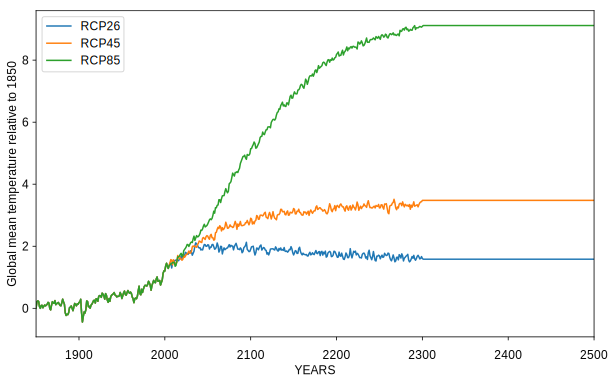

In [6]:
ax = plt.subplot(111)
for scen in ["RCP26","RCP45","RCP85"]:
    magicc_gmt[scen].plot(ax=ax,label=scen)
plt.legend()
plt.ylabel("Global mean temperature relative to 1850")

In [7]:
## You can only use this cell if you have the Deconto & Pollard 2016 data
## Show all RCP responses of Deconto & Pollard (2016)
if show_dp16_data:
    fig = plt.figure(figsize=(10,12))
    axs = [plt.subplot(3,2,i+1) for i in np.arange(6)]
    scens = ["RCP26","RCP26PIT","RCP45","RCP45PIT","RCP85","RCP85PIT"]
    # ax1 = plt.subplot(121)
    # ax2 = plt.subplot(122)
    for i,scen in enumerate(scens):
        dp16_slr_mean[scen].plot(ax=axs[i],legend=False)
    #     dp16_slr_mean["RCP26PIT"].plot(ax=ax2,legend=False)

    labels = ["RCP26 std","RCP26 PIT"]
    for i,ax in enumerate(axs):
        ax.text(0.05, 0.8, scens[i], transform=ax.transAxes,
        fontdict={'family': 'sans-serif', 'weight': 'bold', "size": 12})
        if i%2 == 0:
            ax.set_ylabel("sea level rise in mm")

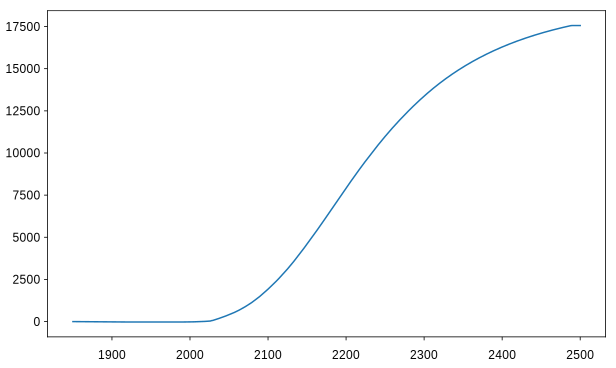

In [8]:
## show a sample Antarctic solid ice discharge response following our parametrization
import fast_ant_sid.fast_ant_sid as fas; reload(fas)
sid_sens, fastrate, temp0, temp_thresh = 1.e-4, 10.1, 0.5, 2.
parameters = (sid_sens, fastrate, temp0, temp_thresh)

# determine maximum volume one time, (taken most sensitive run in year 2500)
# max_volume_to_lose = dp16_slr_mean["RCP85PIT"].max().max()
# we here use the hardcoded value, which is equivalent to dp16_slr_mean["RCP85PIT"].max().max()
max_volume_to_lose = 17560. # in mm

scen = "RCP85"
slr = fas.calc_solid_ice_discharge(magicc_gmt[scen].values,
                                   parameters, max_volume_to_lose,
                                   temp_sensitivity=fas.square)

plt.plot(magicc_gmt[scen].index, slr)

In [9]:
# load the parameters, which have been calibrated with run_calibration.py
parameters_ens = pd.read_csv("../data/parameters/parameters_quadratic.csv",index_col=0)
# make index same datatype as when determined from DP16 files.
parameters_ens.index = [str(idx) for idx in parameters_ens.index]

In [10]:
# get fitted SLR, same anomaly year 1950 as Deconto and Pollard data
slr_fitted = {}

for scen in ["RCP26","RCP45","RCP85"]:
    
    slr_fitted[scen] = collections.OrderedDict()
    
    for index, params in parameters_ens.iterrows():

#         max_volume_to_lose = dp16_slr_mean["RCP85PIT"][index].max()

        slr = fas.calc_solid_ice_discharge(forcing[scen].values, params.values,
                                   max_volume_to_lose,temp_sensitivity=fas.square)
        slr = pd.DataFrame(slr,index=forcing[scen].index,
                                               columns=["slr_projected"])
        slr_fitted[scen][index] = slr - slr.loc[1950]

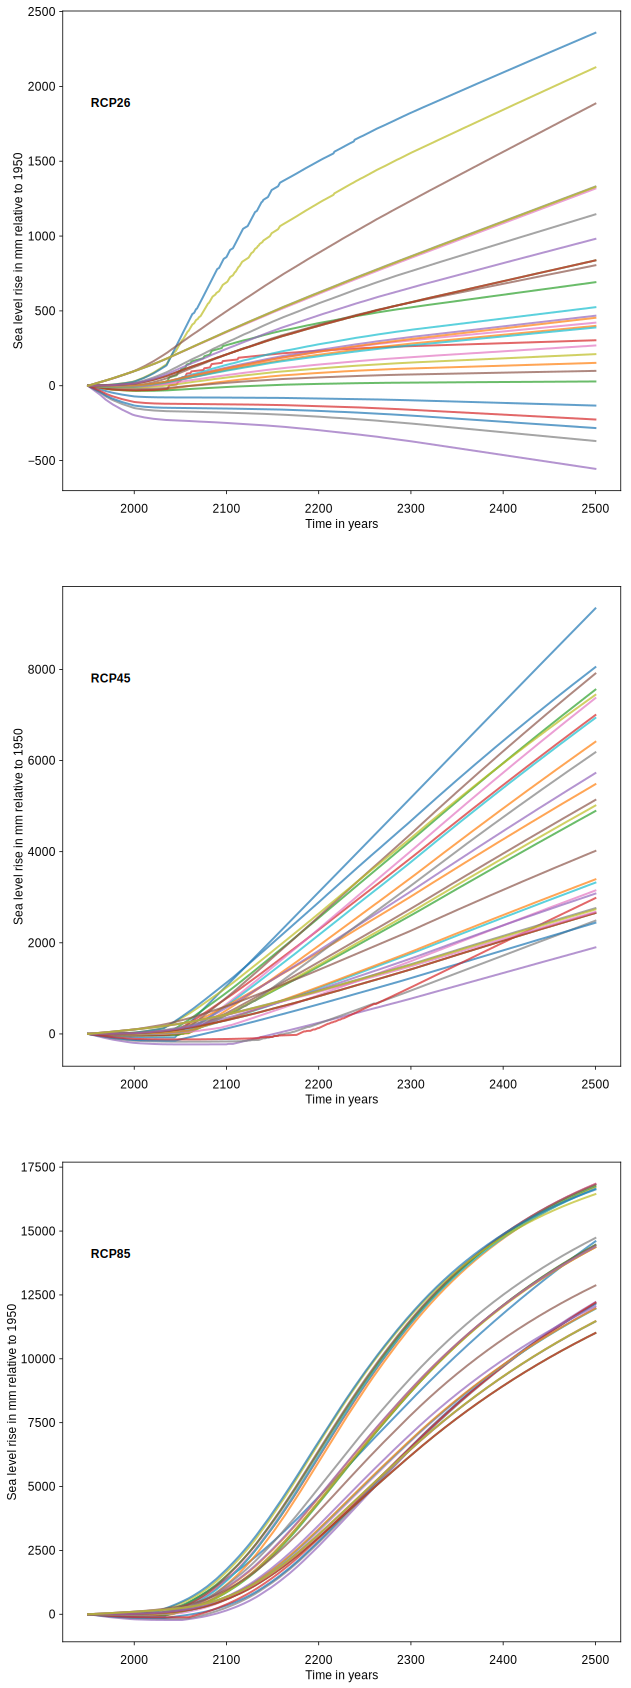

In [11]:
plt.figure(figsize=(10,30))
axs = [plt.subplot(3,1,i+1) for i in np.arange(3)]

endyear = 2500
scenarios = ["RCP26","RCP45","RCP85"]

for i,scen in enumerate(scenarios):
    ax = axs[i]
    for member in slr_fitted[scen].keys()[:]:

        p = ax.plot(slr_fitted[scen][member].loc[1950:endyear].index,
                    slr_fitted[scen][member].loc[1950:endyear],alpha=0.7,lw=2)
        if show_dp16_data:
            try:
                ax.plot(dp16_slr_mean[scen+"PIT"][member].loc[1950:endyear].index,
                        dp16_slr_mean[scen+"PIT"][member].loc[1950:endyear], "--",
                        alpha=0.7,lw=1, color=p[0].get_color())
            except KeyError:
                pass
        
for i,ax in enumerate(axs):
    ax.text(0.05, 0.8, scenarios[i], transform=ax.transAxes,
        fontdict={'family': 'sans-serif', 'weight': 'bold', "size": 12})
    ax.set_ylabel("Sea level rise in mm relative to 1950")
    ax.set_xlabel("Time in years")
    
if show_dp16_data:
    plt.savefig("../figures/deconto_quadratic_sensitivity.pdf", bbox_inches='tight')

In [12]:
def dp16_id_to_int(df):
    return [np.int(st[0:-3]) for st in df.index]

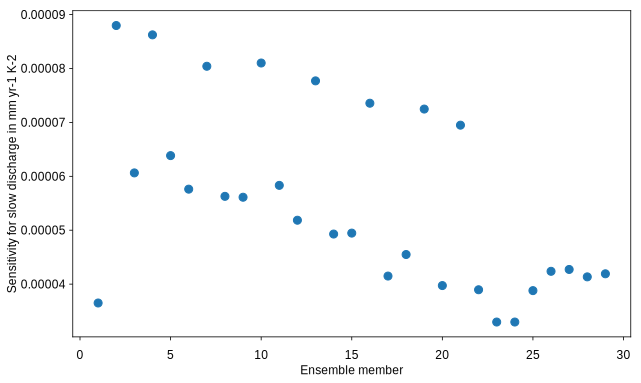

In [13]:
plt.plot(dp16_id_to_int(parameters_ens["sid_sens"]), parameters_ens["sid_sens"],"o")
plt.xlabel("Ensemble member")
l1 = plt.ylabel("Sensitivity for slow discharge in mm yr-1 K-2")

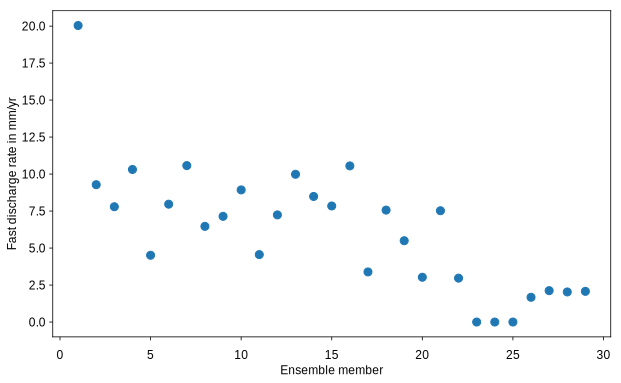

In [14]:
plt.plot(dp16_id_to_int(parameters_ens["fastrate"]), parameters_ens["fastrate"],"o")
plt.xlabel("Ensemble member")
l1 = plt.ylabel("Fast discharge rate in mm/yr")

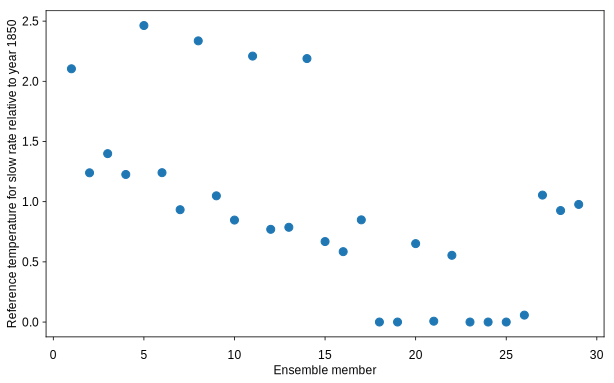

In [15]:
plt.plot(dp16_id_to_int(parameters_ens["temp0"]), parameters_ens["temp0"],"o")
plt.xlabel("Ensemble member")
l1 = plt.ylabel("Reference temperature for slow rate relative to year 1850")

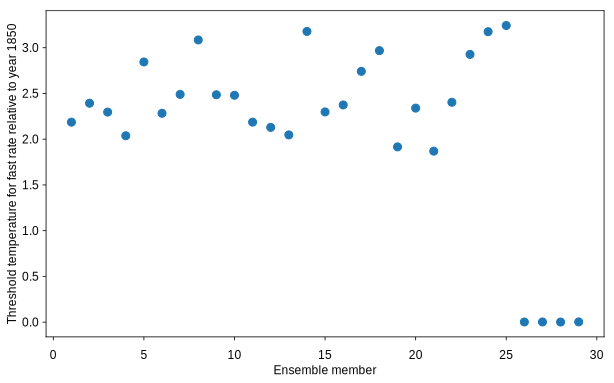

In [16]:
plt.plot(dp16_id_to_int(parameters_ens["temp_thresh"]),parameters_ens["temp_thresh"],"o")
plt.xlabel("Ensemble member")
l1 = plt.ylabel("Threshold temperature for fast rate relative to year 1850")